In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [150]:
import pandas as pd
import numpy as np
import scipy.stats as st
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from imblearn.over_sampling import ADASYN

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import recall_score, log_loss, fbeta_score, f1_score, make_scorer
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import classification_report

from sklearn.datasets import make_classification
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
%matplotlib inline



### Full Dataset

In [7]:
covid_total = pd.read_json('covid_no_nan.json', lines=True)

In [14]:
covid_total_feats = covid_total

In [17]:
covid_total_feats['comorb_count'] = covid_total_feats['diabetes'] + covid_total_feats['copd'] + covid_total_feats['asthma'] + covid_total_feats['hypertension'] + covid_total_feats['other_disease'] + covid_total_feats['cardiovascular'] + covid_total_feats['renal_chronic'] + covid_total_feats['obesity'] + covid_total_feats['tobacco']

In [21]:
covid_total_feats['imm_comorb'] = np.where((covid_total_feats['inmsupr']==1) & (covid_total_feats['comorb_count']>=1), 1,0)

In [25]:
covid_total_feats['imm_covid_pos'] =  np.where((covid_total_feats['inmsupr']==1) & (covid_total_feats['covid_res']==1), 1,0)

In [30]:
covid_total_feats['imm_other_dis'] =  np.where((covid_total_feats['inmsupr']==1) & (covid_total_feats['other_disease']==1), 1,0)

In [33]:
covid_total_feats['imm_lung_disease'] = np.where((covid_total_feats['inmsupr']==1) & \
                                          ((covid_total_feats['pneumonia']==1) | \
                                          (covid_total_feats['asthma']==1) | \
                                          (covid_total_feats['copd']==1) | \
                                          (covid_total_feats['tobacco']==1)), 1, 0)

### Hospitalized Only Dataset

In [8]:
covid_hosp = pd.read_json('covid_hosp_feats.json', lines=True)

In [18]:
covid_hosp['comorb_count'] = covid_hosp['diabetes'] + covid_hosp['copd'] + covid_hosp['asthma'] + covid_hosp['hypertension'] + covid_hosp['other_disease'] + covid_hosp['cardiovascular'] + covid_hosp['renal_chronic'] + covid_hosp['obesity'] + covid_hosp['tobacco']

In [22]:
covid_hosp['imm_comorb'] = np.where((covid_hosp['inmsupr']==1) & (covid_hosp['comorb_count']>=1), 1,0)

In [27]:
covid_hosp['imm_covid_pos'] =  np.where((covid_hosp['inmsupr']==1) & (covid_hosp['covid_res']==1), 1,0)

In [31]:
covid_hosp['imm_other_dis'] =  np.where((covid_hosp['inmsupr']==1) & (covid_hosp['other_disease']==1), 1,0)

In [34]:
covid_hosp['imm_lung_disease'] = np.where((covid_hosp['inmsupr']==1) & \
                                          ((covid_hosp['pneumonia']==1) | \
                                          (covid_hosp['asthma']==1) | \
                                          (covid_hosp['copd']==1) | \
                                          (covid_hosp['tobacco']==1)), 1, 0)

### Immunosuppressed Only Dataset

In [9]:
covid_immun = pd.read_json('covid_immun.json', lines=True)

In [19]:
covid_immun['comorb_count'] = covid_immun['diabetes'] + covid_immun['copd'] + covid_immun['asthma'] + covid_immun['hypertension'] + covid_immun['other_disease'] + covid_immun['cardiovascular'] + covid_immun['renal_chronic'] + covid_immun['obesity'] + covid_immun['tobacco']

In [23]:
covid_immun['imm_comorb'] = np.where((covid_immun['inmsupr']==1) & (covid_immun['comorb_count']>=1), 1,0)

In [26]:
covid_immun['imm_covid_pos'] =  np.where((covid_immun['inmsupr']==1) & (covid_immun['covid_res']==1), 1,0)

In [32]:
covid_immun['imm_other_dis'] =  np.where((covid_immun['inmsupr']==1) & (covid_immun['other_disease']==1), 1,0)

In [35]:
covid_immun['imm_lung_disease'] = np.where((covid_immun['inmsupr']==1) & \
                                          ((covid_immun['pneumonia']==1) | \
                                          (covid_immun['asthma']==1) | \
                                          (covid_immun['copd']==1) | \
                                          (covid_immun['tobacco']==1)), 1, 0)

### Engineered and Categorical Features

In [49]:
covid_total_feats = pd.get_dummies(covid_total_feats, columns=['covid_res'], drop_first=True, prefix='covid_res')
covid_hosp = pd.get_dummies(covid_hosp, columns=['covid_res'], drop_first=True, prefix='covid_res')
covid_immun = pd.get_dummies(covid_immun, columns=['covid_res'], drop_first=True, prefix='covid_res')

In [53]:
covid_total_feats.shape

(561096, 30)

In [54]:
covid_hosp.shape

(120026, 30)

In [55]:
covid_immun.shape

(8870, 30)

In [50]:
covid_total_feats.columns

Index(['id', 'sex', 'patient_type', 'entry_date', 'date_symptoms', 'date_died',
       'intubed', 'pneumonia', 'age', 'pregnancy', 'diabetes', 'copd',
       'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
       'obesity', 'renal_chronic', 'tobacco', 'contact_other_covid', 'icu',
       'passed', 'comorb_count', 'imm_comorb', 'imm_covid_pos',
       'imm_other_dis', 'imm_lung_disease', 'covid_res_1', 'covid_res_2'],
      dtype='object')

In [51]:
covid_hosp.columns

Index(['id', 'sex', 'patient_type', 'entry_date', 'date_symptoms', 'date_died',
       'intubed', 'pneumonia', 'age', 'pregnancy', 'diabetes', 'copd',
       'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
       'obesity', 'renal_chronic', 'tobacco', 'contact_other_covid', 'icu',
       'passed', 'comorb_count', 'imm_comorb', 'imm_covid_pos',
       'imm_other_dis', 'imm_lung_disease', 'covid_res_1', 'covid_res_2'],
      dtype='object')

In [52]:
covid_immun.columns

Index(['id', 'sex', 'patient_type', 'entry_date', 'date_symptoms', 'date_died',
       'intubed', 'pneumonia', 'age', 'pregnancy', 'diabetes', 'copd',
       'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
       'obesity', 'renal_chronic', 'tobacco', 'contact_other_covid', 'icu',
       'passed', 'comorb_count', 'imm_comorb', 'imm_covid_pos',
       'imm_other_dis', 'imm_lung_disease', 'covid_res_1', 'covid_res_2'],
      dtype='object')

In [62]:
categoricals = [ 'sex','patient_type', 'pneumonia', 'diabetes', 'copd', 'asthma', 'inmsupr',
       'hypertension', 'other_disease', 'cardiovascular', 'obesity','renal_chronic', 'tobacco', 
                'pregnancy', 'icu', 'intubed', 'contact_other_covid', 'passed', 'imm_comorb',
       'imm_covid_pos', 'imm_other_dis', 'imm_lung_disease', 'covid_res_1', 'covid_res_2']

In [63]:
covid_total_feats[categoricals] = covid_total_feats[categoricals].astype('category')
covid_hosp[categoricals] = covid_hosp[categoricals].astype('category')
covid_immun[categoricals] = covid_immun[categoricals].astype('category')

In [243]:
strict_features = ['sex',  'age', 'pregnancy', 'diabetes', 'copd','asthma', 'inmsupr', 'hypertension', 
                   'other_disease', 'cardiovascular','obesity', 'renal_chronic', 'tobacco',
                   'contact_other_covid', 'comorb_count', 'imm_comorb', 'imm_covid_pos', 'imm_other_dis', 
                   'imm_lung_disease','covid_res_1', 'covid_res_2']

stricter_features = ['sex', 'age', 'diabetes', 'copd', 'asthma', 'inmsupr', 'hypertension', 'other_disease',
                    'cardiovascular', 'renal_chronic', 'contact_other_covid', 'covid_res_1']

outcomes = [ 'pneumonia','intubed','icu','passed']

## Target: Patient Deaths from COVID

### Immunosuppressed Only: Modeling to Predict Deaths

### Modeling With No Stratification, No Oversampling/Undersampling

In [218]:
# train / test split

base_train, base_test = train_test_split(covid_immun, test_size=0.2, random_state=33)

In [219]:
# train / validation split
base_train, base_val = train_test_split(base_train, test_size=0.2, random_state=33)

In [220]:
xb_train = base_train[strict_features]
yb_train = base_train['passed']

In [221]:
# Scaling
scaler = StandardScaler()
xb_train = scaler.fit_transform(xb_train)

xb_val = scaler.fit_transform(base_val[strict_features])
yb_val = base_val['passed']

In [222]:
# Initializing Model - base
logreg_b = LogisticRegression(solver='saga')

In [223]:
# GridSearch for best parameters, best estimator
params = {
    'C': np.logspace(-3, 3, 7),
    'penalty':['l1', 'l2'],
    'random_state':[33],
    'max_iter': [3000]
}
score = make_scorer(f1_score)

In [224]:
gridsearch_b = GridSearchCV(logreg_b, params, cv=5, scoring=score)
gridsearch_b.fit(xb_train, yb_train)

print("Best parameters: ", gridsearch_b.best_params_)

best_estim_b = gridsearch_b.best_estimator_
print("Best estimator :", best_estim_b)

best_estim_b.fit(xb_train, yb_train)

print("Training scores: ", classification_report(yb_train, best_estim_b.predict(xb_train)))

Best parameters:  {'C': 100.0, 'max_iter': 3000, 'penalty': 'l1', 'random_state': 33}
Best estimator : LogisticRegression(C=100.0, max_iter=3000, penalty='l1', random_state=33,
                   solver='saga')
Training scores:                precision    recall  f1-score   support

           0       0.87      0.98      0.92      4803
           1       0.57      0.18      0.28       873

    accuracy                           0.85      5676
   macro avg       0.72      0.58      0.60      5676
weighted avg       0.82      0.85      0.82      5676



In [225]:
gs_b_preds = best_estim_b.predict(xb_train)
gs_b_conf = confusion_matrix(yb_train, gs_b_preds)
print("Confusion Matrix (Training): ", gs_b_conf)

Confusion Matrix (Training):  [[4686  117]
 [ 715  158]]


In [226]:
print("Validation scores: ", classification_report(yb_val, best_estim_b.predict(xb_val)))

gs_b_val_conf = confusion_matrix(yb_val, best_estim_b.predict(xb_val))
print("Confusion Matrix (Validation): ", gs_b_val_conf)

Validation scores:                precision    recall  f1-score   support

           0       0.88      0.98      0.92      1212
           1       0.60      0.20      0.30       208

    accuracy                           0.86      1420
   macro avg       0.74      0.59      0.61      1420
weighted avg       0.84      0.86      0.83      1420

Confusion Matrix (Validation):  [[1185   27]
 [ 167   41]]


In [233]:
logreg_4 = LogisticRegression(C=500, max_iter=3000, penalty='l1', random_state=33,
                   solver='saga')

In [234]:
logreg_4.fit(xb_train, yb_train)
print("Training scores: ", classification_report(yb_train, logreg_4.predict(xb_train)))

Training scores:                precision    recall  f1-score   support

           0       0.87      0.98      0.92      4803
           1       0.57      0.18      0.28       873

    accuracy                           0.85      5676
   macro avg       0.72      0.58      0.60      5676
weighted avg       0.82      0.85      0.82      5676



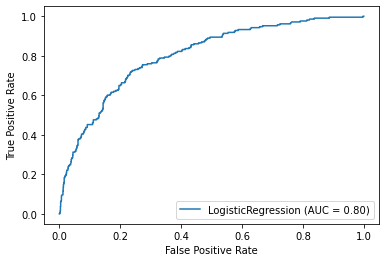

In [240]:
plot_roc_curve(logreg_4, xb_val, yb_val);

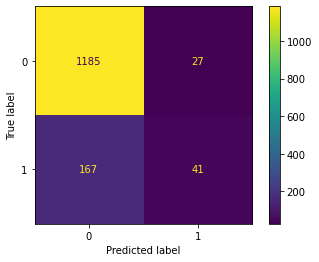

In [242]:
plot_confusion_matrix(logreg_4, xb_val, yb_val);

In [245]:
for feature, coef in zip(covid_immun[strict_features], logreg_4.coef_.T):
    print(feature, coef)

sex [0.15709884]
age [0.43722225]
pregnancy [-0.57105016]
diabetes [0.1062306]
copd [-0.13707014]
asthma [-0.22621143]
inmsupr [0.]
hypertension [0.05116365]
other_disease [0.06245799]
cardiovascular [0.07133529]
obesity [-0.0719865]
renal_chronic [0.15364423]
tobacco [-0.11836819]
contact_other_covid [-0.49066814]
comorb_count [0.00135693]
imm_comorb [9.69918818e-05]
imm_covid_pos [0.24016003]
imm_other_dis [0.06245799]
imm_lung_disease [0.69493726]
covid_res_1 [0.24016003]
covid_res_2 [-0.18175008]


### Modeling with Basic Stratification

In [204]:
# train / test split

i_train, i_test = train_test_split(covid_immun, test_size=0.2, random_state=33, stratify = covid_immun['passed'])

In [205]:
# train / validation split
i_train, i_val = train_test_split(i_train, test_size=0.2, random_state=33, stratify = i_train['passed'])

In [206]:
x_train = i_train[strict_features]
y_train = i_train['passed']

In [207]:
# Scaling
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

x_val = scaler.fit_transform(i_val[strict_features])
y_val = i_val['passed']

In [208]:
# Initializing Model - simple stratified
logreg_ss = LogisticRegression(solver='saga')

In [212]:
# GridSearch for best parameters, best estimator
params = {
    'C': np.logspace(-3, 3, 7),
    'penalty':['l1', 'l2'],
    'random_state':[33],
    'max_iter': [3000]
}
score = make_scorer(f1_score)

In [213]:
gridsearch_ss = GridSearchCV(logreg_ss, params, cv=5, scoring=score)
gridsearch_ss.fit(x_train, y_train)

print("Best parameters: ", gridsearch_ss.best_params_)

best_estim_ss = gridsearch_ss.best_estimator_
print("Best estimator :", best_estim_ss)

best_estim_ss.fit(x_train, y_train)

print("Training scores: ", classification_report(y_train, best_estim_ss.predict(x_train)))

Best parameters:  {'C': 10.0, 'max_iter': 3000, 'penalty': 'l1', 'random_state': 33}
Best estimator : LogisticRegression(C=10.0, max_iter=3000, penalty='l1', random_state=33,
                   solver='saga')
Training scores:                precision    recall  f1-score   support

           0       0.87      0.98      0.92      4820
           1       0.59      0.20      0.29       856

    accuracy                           0.86      5676
   macro avg       0.73      0.59      0.61      5676
weighted avg       0.83      0.86      0.83      5676



In [214]:
gs_ss_preds = best_estim_ss.predict(x_train)
gs_ss_conf = confusion_matrix(y_train, gs_ss_preds)
print("Confusion Matrix (Training): ", gs_ss_conf)

Confusion Matrix (Training):  [[4702  118]
 [ 689  167]]


In [215]:
print("Validation scores: ", classification_report(y_val, best_estim_ss.predict(x_val)))

gs_ss_val_conf = confusion_matrix(y_val, best_estim_ss.predict(x_val))
print("Confusion Matrix (Validation): ", gs_ss_val_conf)

Validation scores:                precision    recall  f1-score   support

           0       0.87      0.98      0.92      1206
           1       0.65      0.20      0.31       214

    accuracy                           0.86      1420
   macro avg       0.76      0.59      0.62      1420
weighted avg       0.84      0.86      0.83      1420

Confusion Matrix (Validation):  [[1183   23]
 [ 171   43]]


In [216]:
xtest = i_test[strict_features]
ytest = i_test['passed']

In [217]:
# test set results
gs_ss_test_preds = best_estim_ss.predict(xtest)
gs_ss_test_conf = confusion_matrix(ytest, gs_ss_test_preds)
print("Confusion Matrix (Test Set): ", gs_ss_test_conf)

Confusion Matrix (Test Set):  [[  61 1445]
 [   6  262]]


### Modeling with Adaptive Synthetic Oversampling

In [188]:
# train / test split

i_train, i_test = train_test_split(covid_immun, test_size=0.2, random_state=33)

In [189]:
# train / validation split
i_train, i_val = train_test_split(i_train, test_size=0.2, random_state=33)

In [190]:
xitrain = i_train[strict_features]
yitrain = i_train['passed']

In [191]:
# Addressing class imbalance
Xi_adasyn, yi_adasyn = ADASYN(random_state=33).fit_sample(xitrain, yitrain)
Counter(yi_adasyn)

Counter({0: 4803, 1: 4788})

In [192]:
# Scaling
scaler = StandardScaler()
Xi_adasyn = scaler.fit_transform(Xi_adasyn)

xi_val = scaler.fit_transform(i_val[strict_features])
yi_val = i_val['passed']

In [193]:
# Initializing Model
logreg_i = LogisticRegression(solver='saga')

In [194]:
# GridSearch for best parameters, best estimator
params = {
    'C': np.logspace(-3, 3, 7),
    'penalty':['l1', 'l2'],
    'random_state':[33],
    'max_iter': [5000]
}
make_scorer(f1_score)

make_scorer(f1_score)

In [195]:
gridsearch = GridSearchCV(logreg_i, params, cv=5, scoring=score)
gridsearch.fit(Xi_adasyn, yi_adasyn)

print("Best parameters: ", gridsearch.best_params_)

best_estim = gridsearch.best_estimator_
print("Best estimator :", best_estim)

best_estim.fit(Xi_adasyn, yi_adasyn)

print("Training scores: ", classification_report(yi_adasyn, best_estim.predict(Xi_adasyn)))

Best parameters:  {'C': 0.001, 'max_iter': 5000, 'penalty': 'l1', 'random_state': 33}
Best estimator : LogisticRegression(C=0.001, max_iter=5000, penalty='l1', random_state=33,
                   solver='saga')
Training scores:                precision    recall  f1-score   support

           0       0.83      0.33      0.48      4803
           1       0.58      0.93      0.72      4788

    accuracy                           0.63      9591
   macro avg       0.71      0.63      0.60      9591
weighted avg       0.71      0.63      0.60      9591



In [196]:
gsi_preds = best_estim.predict(Xi_adasyn)
gsi_conf = confusion_matrix(yi_adasyn, gsi_preds)
print("Confusion Matrix (Training): ", gsi_conf)

Confusion Matrix (Training):  [[1599 3204]
 [ 321 4467]]


In [197]:
print("Validation scores: ", classification_report(yi_val, best_estim.predict(xi_val)))

gsi_val_conf = confusion_matrix(yi_val, best_estim.predict(xi_val))
print("Confusion Matrix (Validation): ", gsi_val_conf)

Validation scores:                precision    recall  f1-score   support

           0       0.95      0.29      0.44      1212
           1       0.18      0.92      0.30       208

    accuracy                           0.38      1420
   macro avg       0.57      0.60      0.37      1420
weighted avg       0.84      0.38      0.42      1420

Confusion Matrix (Validation):  [[349 863]
 [ 17 191]]


In [198]:
for feature, coef in zip(covid_immun[strict_features], best_estim.coef_.T):
    print(feature, coef)

sex [0.]
age [0.05673535]
pregnancy [0.]
diabetes [0.]
copd [0.]
asthma [0.]
inmsupr [0.]
hypertension [0.]
other_disease [0.]
cardiovascular [0.]
obesity [0.]
renal_chronic [0.]
tobacco [0.]
contact_other_covid [-0.25406152]
comorb_count [0.]
imm_comorb [0.]
imm_covid_pos [0.]
imm_other_dis [0.]
imm_lung_disease [0.]
covid_res_1 [0.]
covid_res_2 [0.]


In [199]:
xtest = i_test[strict_features]
ytest = i_test['passed']

In [200]:
# test set results
gsi_test_preds = best_estim.predict(xtest)
gsi_test_conf = confusion_matrix(ytest, gsi_test_preds)
print("Confusion Matrix (Test Set): ", gsi_test_conf)

Confusion Matrix (Test Set):  [[  23 1494]
 [   2  255]]


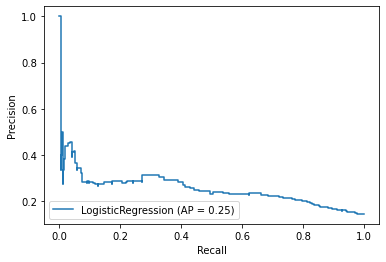

In [201]:
# test set graphing, visualization
plot_precision_recall_curve(best_estim, xtest, ytest)

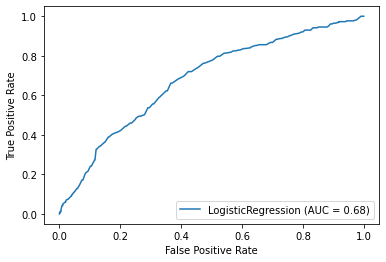

In [202]:
plot_roc_curve(best_estim, xtest, ytest)

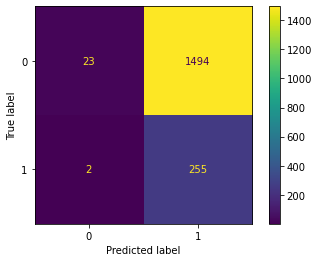

In [203]:
plot_confusion_matrix(best_estim, xtest, ytest)

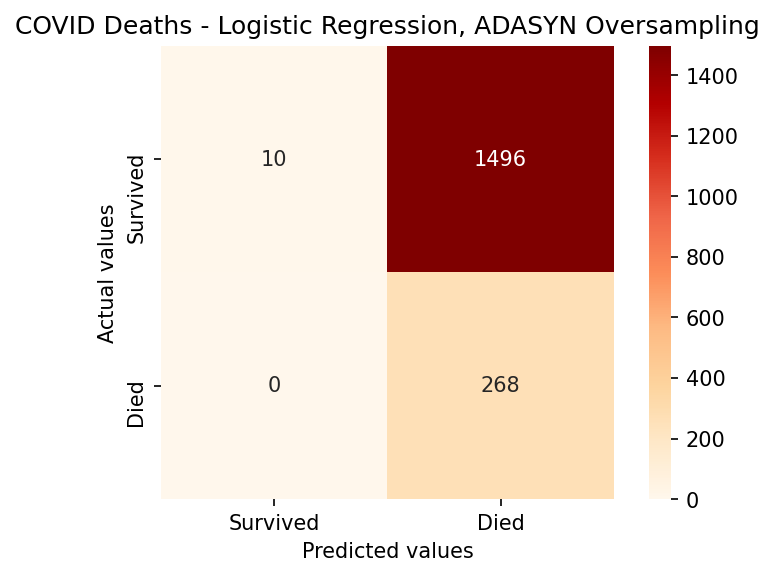

In [154]:
plt.figure(dpi=150)
sns.heatmap(gsi_test_conf, cmap=plt.cm.OrRd, annot=True, fmt='d', square=True,
           xticklabels=['Survived', 'Died'],
           yticklabels=['Survived', 'Died'])

plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('COVID Deaths - Logistic Regression, ADASYN Oversampling')
plt.savefig('COVID_LR_GSCV_ADASYN_matrix', dpi=600, bbox_inches='tight');

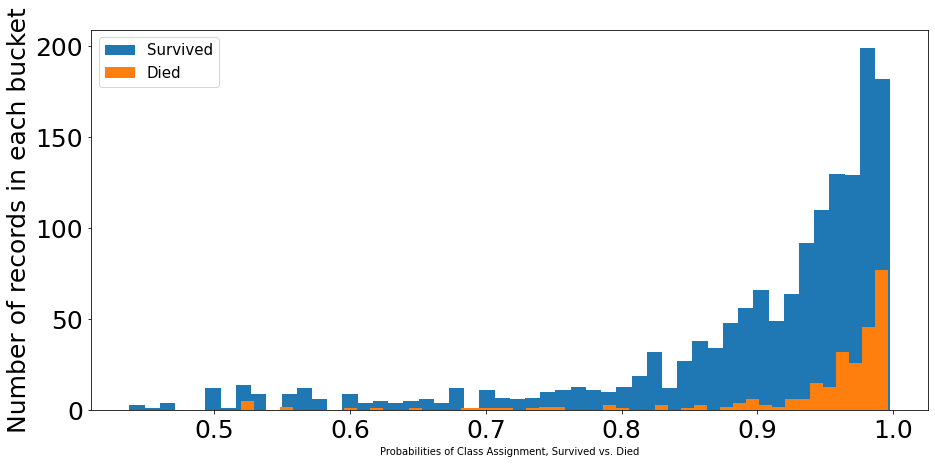

In [156]:
probas= best_estim.predict_proba(xtest)[:,1]

plt.figure(figsize=(15,7))
plt.hist(probas[ytest==0], bins=50, label='Survived')
plt.hist(probas[ytest==1], bins=50, label='Died')
plt.xlabel('Probabilities of Class Assignment, Survived vs. Died')
plt.ylabel('Number of records in each bucket', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show();

In [170]:
logreg_i2 = LogisticRegression(solver='saga', C=.05, penalty='l1', random_state=33)

In [171]:
logreg_i2.fit(Xi_adasyn, yi_adasyn)
print("Training scores: ", classification_report(yi_adasyn, logreg_i2.predict(Xi_adasyn)))

Training scores:                precision    recall  f1-score   support

           0       0.76      0.76      0.76      4820
           1       0.76      0.77      0.77      4912

    accuracy                           0.76      9732
   macro avg       0.76      0.76      0.76      9732
weighted avg       0.76      0.76      0.76      9732



In [172]:
lr2_preds = logreg_i2.predict(Xi_adasyn)
lr2_conf = confusion_matrix(yi_adasyn, lr2_preds)
print("Confusion Matrix (Training): ", lr2_conf)

Confusion Matrix (Training):  [[3659 1161]
 [1145 3767]]


In [173]:
print("Validation scores: ", classification_report(yi_val, logreg_i2.predict(xi_val)))

lr2_val_conf = confusion_matrix(yi_val, logreg_i2.predict(xi_val))
print("Confusion Matrix (Validation): ", lr2_val_conf)

Validation scores:                precision    recall  f1-score   support

           0       0.95      0.45      0.61      1206
           1       0.22      0.87      0.35       214

    accuracy                           0.51      1420
   macro avg       0.59      0.66      0.48      1420
weighted avg       0.84      0.51      0.57      1420

Confusion Matrix (Validation):  [[539 667]
 [ 27 187]]


In [185]:
xtest = i_test[strict_features]
ytest = i_test['passed']

In [175]:
# test set results
print("Test scores: ", classification_report(ytest, logreg_i2.predict(xtest)))

lr2_test_conf = confusion_matrix(ytest, logreg_i2.predict(xtest))
print("Confusion Matrix (Test Set): ", lr2_test_conf)

Test scores:                precision    recall  f1-score   support

           0       1.00      0.00      0.00      1506
           1       0.15      1.00      0.26       268

    accuracy                           0.15      1774
   macro avg       0.58      0.50      0.13      1774
weighted avg       0.87      0.15      0.04      1774

Confusion Matrix (Test Set):  [[   3 1503]
 [   0  268]]


In [180]:
logreg_i3 = LogisticRegression()

In [181]:
# GridSearch for best parameters, best estimator
params = {
    'C': np.logspace(-3, 3, 7),
    'penalty':['l2'],
    'random_state':[33],
    'max_iter': [5000]
}
make_scorer(f1_score)

make_scorer(f1_score)

In [182]:
gridsearch_i3 = GridSearchCV(logreg_i3, params, cv=5, scoring=score)
gridsearch_i3.fit(Xi_adasyn, yi_adasyn)

print("Best parameters: ", gridsearch_i3.best_params_)

best_estim_i3 = gridsearch_i3.best_estimator_
print("Best estimator :", best_estim_i3)

best_estim_i3.fit(Xi_adasyn, yi_adasyn)

print("Training scores: ", classification_report(yi_adasyn, best_estim_i3.predict(Xi_adasyn)))

Best parameters:  {'C': 0.01, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 33}
Best estimator : LogisticRegression(C=0.01, max_iter=5000, random_state=33)
Training scores:                precision    recall  f1-score   support

           0       0.77      0.72      0.74      4820
           1       0.74      0.79      0.77      4912

    accuracy                           0.76      9732
   macro avg       0.76      0.76      0.76      9732
weighted avg       0.76      0.76      0.76      9732



In [184]:
lr3_preds = best_estim_i3.predict(Xi_adasyn)
lr3_conf = confusion_matrix(yi_adasyn, lr3_preds)
print("Confusion Matrix (Training): ", lr3_conf)

Confusion Matrix (Training):  [[3448 1372]
 [1007 3905]]


In [187]:
# test set results
print("Test scores: ", classification_report(ytest, best_estim_i3.predict(xtest)))

lr3_test_conf = confusion_matrix(ytest, best_estim_i3.predict(xtest))
print("Confusion Matrix (Test Set): ", lr3_test_conf)

Test scores:                precision    recall  f1-score   support

           0       1.00      0.00      0.01      1506
           1       0.15      1.00      0.26       268

    accuracy                           0.15      1774
   macro avg       0.58      0.50      0.13      1774
weighted avg       0.87      0.15      0.05      1774

Confusion Matrix (Test Set):  [[   5 1501]
 [   0  268]]


In [ ]:
import pickle
import os

if not os.path.exists('models'):
    os.makedirs('models')
    

with open(f'models/{LR_GSCV_ADASYN_immun}.pickle', 'wb') as pfile:
     pickle.dump(best_estim)

### Hospitalized Only: Modeling To Predict COVID Deaths

In [121]:
# train / test split

h_train, h_test = train_test_split(covid_hosp, test_size=0.2, random_state=33, stratify=covid_hosp['passed'])

In [122]:
# train / validation split
h_train, h_val = train_test_split(h_train, test_size=0.2, random_state=33, stratify=h_train['passed'])

In [123]:
xhtrain = h_train[strict_features]
yhtrain = h_train['passed']

In [124]:
# Addressing class imbalance
Xh_adasyn, yh_adasyn = ADASYN(random_state=33).fit_sample(xhtrain, yhtrain)
Counter(yh_adasyn)

Counter({0: 56369, 1: 55828})

In [125]:
# Scaling
scaler = StandardScaler()
Xh_adasyn = scaler.fit_transform(Xh_adasyn)

xh_val = scaler.fit_transform(h_val[strict_features])
yh_val = h_val['passed']

In [127]:
# Initializing Model
logreg_h = LogisticRegression(solver='saga')

In [128]:
# GridSearch for best parameters, best estimator
params = {
    'C': np.logspace(-3, 3, 7),
    'penalty':['l1', 'l2'],
    'random_state':[33],
    'max_iter': [5000]
}
make_scorer(f1_score)

make_scorer(f1_score)

In [129]:
gridsearch_h = GridSearchCV(logreg_h, params, cv=5, scoring=score)
gridsearch_h.fit(Xh_adasyn, yh_adasyn)

print("Best parameters: ", gridsearch_h.best_params_)

best_estim_h = gridsearch_h.best_estimator_
print("Best estimator :", best_estim_h)

best_estim_h.fit(Xh_adasyn, yh_adasyn)

print("Training scores: ", classification_report(yh_adasyn, best_estim_h.predict(Xh_adasyn)))

Best parameters:  {'C': 0.001, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 33}
Best estimator : LogisticRegression(C=0.001, max_iter=5000, random_state=33, solver='saga')
Training scores:                precision    recall  f1-score   support

           0       0.68      0.59      0.64     56369
           1       0.64      0.72      0.68     55828

    accuracy                           0.66    112197
   macro avg       0.66      0.66      0.66    112197
weighted avg       0.66      0.66      0.66    112197



In [136]:
gsh_preds = best_estim_h.predict(Xh_adasyn)
gsh_conf = confusion_matrix(yh_adasyn, gsh_preds)
print("Confusion Matrix (Training): ", gsh_conf)

Confusion Matrix (Training):  [[33447 22922]
 [15451 40377]]


In [137]:
print("Validation scores: ", classification_report(yh_val, best_estim_h.predict(xh_val)))

gsh_val_conf = confusion_matrix(yh_val, best_estim_h.predict(xh_val))
print("Confusion Matrix (Validation): ", gsh_val_conf)

Validation scores:                precision    recall  f1-score   support

           0       0.87      0.53      0.66     14092
           1       0.38      0.78      0.51      5112

    accuracy                           0.60     19204
   macro avg       0.62      0.66      0.58     19204
weighted avg       0.74      0.60      0.62     19204

Confusion Matrix (Validation):  [[7516 6576]
 [1137 3975]]


In [138]:
for feature, coef in zip(covid_hosp[strict_features], best_estim_h.coef_.T):
    print(feature, coef)

sex [0.08259293]
age [0.47234919]
pregnancy [-0.14960813]
diabetes [-0.16106479]
copd [-0.15961676]
asthma [-0.19496643]
inmsupr [-0.07522039]
hypertension [-0.19269785]
other_disease [-0.1310629]
cardiovascular [-0.15413393]
obesity [-0.15582114]
renal_chronic [-0.09864176]
tobacco [-0.1877712]
contact_other_covid [-0.31512152]
comorb_count [0.60068664]
imm_comorb [-0.02619142]
imm_covid_pos [0.01639943]
imm_other_dis [0.02487082]
imm_lung_disease [0.07670125]
covid_res_1 [0.2966205]
covid_res_2 [-0.23956453]


### Complete Dataset: Modeling to Predict Deaths (Do Not Run w ADASYN)

In [139]:
# train / test split
f_train, f_test = train_test_split(covid_total_feats, test_size=0.2, random_state=33, stratify=covid_total_feats['passed'])

In [140]:
# train / validation split
f_train, f_val = train_test_split(f_train, test_size=0.2, random_state=33, stratify=f_train['passed'])

In [141]:
xftrain = f_train[strict_features]
yftrain = f_train['passed']

In [142]:
# Addressing class imbalance
Xf_adasyn, yf_adasyn = ADASYN(random_state=33).fit_sample(xftrain, yftrain)
Counter(yf_adasyn)

Counter({0: 336378, 1: 332776})

In [143]:
# Scaling
scaler = StandardScaler()
Xf_adasyn = scaler.fit_transform(Xf_adasyn)

xf_val = scaler.fit_transform(f_val[strict_features])
yf_val = f_val['passed']

In [144]:
# Initializing Model
logreg_f = LogisticRegression(solver='saga')

In [145]:
# GridSearch for best parameters, best estimator
params = {
    'C': np.logspace(-3, 3, 7),
    'penalty':['l1', 'l2'],
    'random_state':[33],
    'max_iter': [5000]
}
make_scorer(f1_score)

make_scorer(f1_score)

In [146]:
gridsearch_f = GridSearchCV(logreg_f, params, cv=5, scoring=score)
gridsearch_f.fit(Xf_adasyn, yf_adasyn)

print("Best parameters on full dataset: ", gridsearch_f.best_params_)

best_estim_f = gridsearch_f.best_estimator_
print("Best estimator on full dataset:", best_estim_f)

best_estim_f.fit(Xf_adasyn, yf_adasyn)

print("Training scores on full dataset: ", classification_report(yf_adasyn, best_estim_f.predict(Xf_adasyn)))

KeyboardInterrupt: 

In [ ]:
gsf_preds = best_estim_f.predict(Xf_adasyn)
gsf_conf = confusion_matrix(yf_adasyn, gsf_preds)
print("Confusion Matrix (Training): ", gsf_conf)

In [ ]:
print("Validation scores: ", classification_report(yf_val, best_estim_f.predict(xf_val)))

gsf_val_conf = confusion_matrix(yf_val, best_estim_f.predict(xf_val))
print("Confusion Matrix (Validation): ", gsf_val_conf)

In [ ]:
for feature, coef in zip(covid_total_feats[strict_features], best_estim_f.coef_.T):
    print(feature, coef)

## Target: Modeling for Pneumonia


### Immunosuppressed Subset, Modeling to Predict Pneumonia

In [ ]:
# train / test split
ip_train, ip_test = train_test_split(covid_immun, test_size=0.2, random_state=33, stratify=covid_immun['pneumonia'])

In [ ]:
# train / validation split
ip_train, ip_val = train_test_split(ip_train, test_size=0.2, random_state=33, stratify=ip_train['pneumonia'])

In [ ]:
xiptrain = ip_train[strict_features]
yiptrain = ip_train['pneumonia']

In [ ]:
# Addressing class imbalance
Xip_adasyn, yip_adasyn = ADASYN(random_state=33).fit_sample(xiptrain, yiptrain)
Counter(yip_adasyn)

In [ ]:
# Scaling
scaler = StandardScaler()
Xip_adasyn = scaler.fit_transform(Xip_adasyn)

xip_val = scaler.fit_transform(ip_val[strict_features])
yip_val = ip_val['pneumonia']

In [ ]:
# Initializing Model
logreg_ip = LogisticRegression(solver='saga')

In [ ]:
gridsearch_ip = GridSearchCV(logreg_ip, params, cv=5, scoring=score)
gridsearch_ip.fit(Xip_adasyn, yip_adasyn)

print("Best parameters on immun dataset: ", gridsearch_ip.best_params_)

best_estim_ip = gridsearch_ip.best_estimator_
print("Best estimator on immun dataset:", best_estim_ip)

best_estim_ip.fit(Xip_adasyn, yip_adasyn)

print("Training scores on immun dataset: ", classification_report(yip_adasyn, best_estim_ip.predict(Xip_adasyn)))

In [ ]:
gsip_preds = best_estim_ip.predict(Xip_adasyn)
gsip_conf = confusion_matrix(yip_adasyn, gsip_preds)
print("Confusion Matrix (Training): ", gsip_conf)

In [ ]:
print("Validation scores: ", classification_report(yip_val, best_estim_ip.predict(xip_val)))

gsip_val_conf = confusion_matrix(yip_val, best_estim_ip.predict(xip_val))
print("Confusion Matrix (Validation): ", gsip_val_conf)

In [ ]:
for feature, coef in zip(covid_immun[strict_features], best_estim_ip.coef_.T):
    print(feature, coef)

## Target: Modeling To Predict Intubation

### Immunosuppressed Dataset, Modeling to Predict Intubation

In [ ]:
# train / test split
iin_train, iin_test = train_test_split(covid_immun, test_size=0.2, random_state=33, stratify=covid_immun['intubation'])

In [ ]:
# train / validation split
iin_train, iin_val = train_test_split(iin_train, test_size=0.2, random_state=33, stratify=iin_train['intubation'])

In [ ]:
xiintrain = iin_train[strict_features]
yiintrain = iin_train['intubation']

In [ ]:
# Addressing class imbalance
Xiin_adasyn, yiin_adasyn = ADASYN(random_state=33).fit_sample(xiintrain, yiintrain)
Counter(yiin_adasyn)

In [ ]:
# Scaling
scaler = StandardScaler()
Xiin_adasyn = scaler.fit_transform(Xiin_adasyn)

xiin_val = scaler.fit_transform(iin_val[strict_features])
yiin_val = iin_val['intubation']

In [ ]:
# Initializing Model
logreg_iin = LogisticRegression(solver='saga')

In [ ]:
gridsearch_iin = GridSearchCV(logreg_iin, params, cv=5, scoring=score)
gridsearch_iin.fit(Xiin_adasyn, yiin_adasyn)

print("Best parameters on full dataset: ", gridsearch_iin.best_params_)

best_estim_iin = gridsearch_iin.best_estimator_
print("Best estimator on full dataset:", best_estim_iin)

best_estim_iin.fit(Xiin_adasyn, yiin_adasyn)

print("Training scores on full dataset: ", classification_report(yiin_adasyn, best_estim_iin.predict(Xiin_adasyn)))

In [ ]:
gsin_preds = best_estim_iin.predict(Xiin_adasyn)
gsin_conf = confusion_matrix(yiin_adasyn, gsin_preds)
print("Confusion Matrix (Training): ", gsin_conf)

In [ ]:
print("Validation scores: ", classification_report(yiin_val, best_estim_iin.predict(xiin_val)))

gsin_val_conf = confusion_matrix(yiin_val, best_estim_iin.predict(xiin_val))
print("Confusion Matrix (Validation): ", gsin_val_conf)

In [ ]:
for feature, coef in zip(covid_immun[strict_features], best_estim_iin.coef_.T):
    print(feature, coef)

## Target: Modeling To Predict ICU Admission

### Immunosuppressed Subset, Predicting ICU Admission

In [ ]:
# train / test split
iic_train, iic_test = train_test_split(covid_immun, test_size=0.2, random_state=33, stratify=covid_immun['icu'])

In [ ]:
# train / validation split
iic_train, iic_val = train_test_split(iic_train, test_size=0.2, random_state=33, stratify=iic_train['icu'])

In [ ]:
xiictrain = iic_train[strict_features]
yiictrain = iic_train['icu']

In [ ]:
# Addressing class imbalance
Xiic_adasyn, yiic_adasyn = ADASYN(random_state=33).fit_sample(xiictrain, yiictrain)
Counter(yiic_adasyn)

In [ ]:
# Scaling
scaler = StandardScaler()
Xiic_adasyn = scaler.fit_transform(Xiic_adasyn)

xiic_val = scaler.fit_transform(iic_val[strict_features])
yiic_val = iic_val['icu']

In [ ]:
# Initializing Model
logreg_iic = LogisticRegression(solver='saga')

In [ ]:
gridsearch_iic = GridSearchCV(logreg_iic, params, cv=5, scoring=score)
gridsearch_iic.fit(Xiic_adasyn, yiic_adasyn)

print("Best parameters on immun dataset: ", gridsearch_iic.best_params_)

best_estim_iic = gridsearch_iic.best_estimator_
print("Best estimator on immun dataset:", best_estim_iic)

best_estim_iic.fit(Xiic_adasyn, yiic_adasyn)

print("Training scores on full dataset: ", classification_report(yiic_adasyn, best_estim_iic.predict(Xiic_adasyn)))

In [ ]:
gsic_preds = best_estim_iic.predict(Xiic_adasyn)
gsic_conf = confusion_matrix(yiic_adasyn, gsic_preds)
print("Confusion Matrix (Training): ", gsic_conf)

In [ ]:
print("Validation scores: ", classification_report(yiic_val, best_estim_iic.predict(xiic_val)))

gsic_val_conf = confusion_matrix(yiic_val, best_estim_iic.predict(xiic_val))
print("Confusion Matrix (Validation): ", gsic_val_conf)

In [ ]:
for feature, coef in zip(covid_immun[strict_features], best_estim_iic.coef_.T):
    print(feature, coef)

### Complete Dataset: Modeling to Predict Hospitalization

In [ ]:
# train / test split
fh_train, fh_test = train_test_split(covid_total_feats, test_size=0.2, random_state=33, stratify=covid_total_feats['patient_type'])

In [ ]:
# train / validation split
fh_train, fh_val = train_test_split(fh_train, test_size=0.2, random_state=33, stratify=fh_train['patient_type'])

In [ ]:
# defining our target and features
xfhtrain = fh_train[strict_features]
yfhtrain = fh_train['patient_type']

In [ ]:
# Addressing class imbalance
Xfh_adasyn, yfh_adasyn = ADASYN(random_state=33).fit_sample(xfhtrain, yfhtrain)
Counter(yfh_adasyn)

In [ ]:
# Scaling
scaler = StandardScaler()
Xfh_adasyn = scaler.fit_transform(Xfh_adasyn)

xfh_val = scaler.fit_transform(fh_val[strict_features])
yfh_val = fh_val['passed']

In [ ]:
# Initializing Model
logreg_fh = LogisticRegression(solver='saga')

In [ ]:
# GridSearch for best parameters, best estimator
params = {
    'C': np.logspace(-3, 3, 7),
    'penalty':['l1', 'l2'],
    'random_state':[33],
    'max_iter': [5000]
}
make_scorer(f1_score)

In [ ]:
gridsearch_fh = GridSearchCV(logreg_fh, params, cv=5, scoring=score)
gridsearch_fh.fit(Xfh_adasyn, yfh_adasyn)

print("Best parameters on full dataset: ", gridsearch_fh.best_params_)

best_estim_fh = gridsearch_fh.best_estimator_
print("Best estimator on full dataset:", best_estim_fh)

best_estim_fh.fit(Xfh_adasyn, yfh_adasyn)

print("Training scores on full dataset: ", classification_report(yfh_adasyn, best_estim_fh.predict(Xfh_adasyn))

In [ ]:
gsfh_preds = best_estim_fh.predict(Xfh_adasyn)
gsfh_conf = confusion_matrix(yfh_adasyn, gsfh_preds)
print("Confusion Matrix (Training): ", gsfh_conf)

In [ ]:
print("Validation scores: ", classification_report(yfh_val, best_estim_fh.predict(xfh_val)))

gsfh_val_conf = confusion_matrix(yfh_val, best_estim_fh.predict(xfh_val))
print("Confusion Matrix (Validation): ", gsfh_val_conf)

In [ ]:
for feature, coef in zip(covid_total_feats[strict_features], best_estim_fh.coef_.T):
    print(feature, coef)

### Complete Dataset: Modeling to Predict Pneumonia

In [ ]:
# train / test split
fp_train, fp_test = train_test_split(covid_total_feats, test_size=0.2, random_state=33, stratify=covid_total_feats['pneumonia'])

In [ ]:
# train / validation split
fp_train, fp_val = train_test_split(fp_train, test_size=0.2, random_state=33, stratify=fp_train['pneumonia'])

In [ ]:
# defining our target and features
xfptrain = fp_train[strict_features]
yfptrain = fp_train['pneumonia']

In [ ]:
# Addressing class imbalance
Xfp_adasyn, yfp_adasyn = ADASYN(random_state=33).fit_sample(xfptrain, yfptrain)
Counter(yfp_adasyn)

In [ ]:
# Scaling
scaler = StandardScaler()
Xfp_adasyn = scaler.fit_transform(Xfp_adasyn)

xfp_val = scaler.fit_transform(fp_val[strict_features])
yfp_val = fp_val['pneumonia']

In [ ]:
# Initializing Model
logreg_p = LogisticRegression(solver='saga')

In [ ]:
# GridSearch for best parameters, best estimator
params = {
    'C': np.logspace(-3, 3, 7),
    'penalty':['l1', 'l2'],
    'random_state':[33],
    'max_iter': [5000]
}
make_scorer(f1_score)

In [ ]:
gridsearch_fp = GridSearchCV(logreg_p, params, cv=5, scoring=score)
gridsearch_fp.fit(Xfp_adasyn, yfp_adasyn)

print("Best parameters on full dataset: ", gridsearch_fp.best_params_)

best_estim_fp = gridsearch_fp.best_estimator_
print("Best estimator on full dataset:", best_estim_fp)

best_estim_fp.fit(Xfp_adasyn, yfp_adasyn)

print("Training scores on full dataset: ", classification_report(yfp_adasyn, best_estim_fp.predict(Xfp_adasyn))

In [ ]:
gsp_preds = best_estim_fp.predict(Xfp_adasyn)
gsp_conf = confusion_matrix(yfp_adasyn, gsfp_preds)
print("Confusion Matrix (Training): ", gsfp_conf)

In [ ]:
print("Validation scores: ", classification_report(yfp_val, best_estim_fp.predict(xfp_val)))

gsp_val_conf = confusion_matrix(yfp_val, best_estim_fp.predict(xfp_val))
print("Confusion Matrix (Validation): ", gsp_val_conf)

In [ ]:
for feature, coef in zip(covid_total_feats[strict_features], best_estim_fp.coef_.T):
    print(feature, coef)

### Complete Dataset: Modeling to Predict Intubation

### Complete Dataset: Modeling to Predict ICU Admission